Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

In [50]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = 'data/'

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'train_features.csv'), 
                 pd.read_csv(DATA_PATH+'train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'sample_submission.csv')

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [63]:
test.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [64]:
#get the mean baseline
train['status_group'].value_counts(normalize=True)
# train['permit'].isnull().sum()

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [65]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
      
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [66]:
# The status_group column is the target
target = 'status_group'

# Set features to drop
todrop = [target, 'id', 'recorded_by', 
         'extraction_type_group','extraction_type_class', 
         'payment', 'source_type', 'quantity_group',
         'source_class']

#readded 'waterpoint_type_group',  'region_code',

# Get a dataframe with all train columns except todrop features
train_features = train.drop(columns= todrop)

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)
len(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'management', 'management_group', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'waterpoint_type', 'waterpoint_type_group']


24

In [67]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
X_val = val[features]
y_val = val[target]
# y_test = test[target]

In [68]:
#check output is as desired (cleaned dataset)
X_test.head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,basin,...,extraction_type,management,management_group,payment_type,water_quality,quality_group,quantity,source,waterpoint_type,waterpoint_type_group
0,0.0,1996,35.290799,-4.059696,0,21,3,321,2012,Internal,...,other,parastatal,parastatal,never pay,soft,good,seasonal,rainwater harvesting,other,other
1,0.0,1569,36.656709,-3.309214,0,2,2,300,2000,Pangani,...,gravity,vwc,user-group,never pay,soft,good,insufficient,spring,communal standpipe,communal standpipe
2,0.0,1567,34.767863,-5.004344,0,13,2,500,2010,Internal,...,other,vwc,user-group,never pay,soft,good,insufficient,rainwater harvesting,other,other
3,0.0,267,38.058046,-9.418672,0,80,43,250,1987,Ruvuma / Southern Coast,...,other,vwc,user-group,unknown,soft,good,dry,shallow well,other,other
4,500.0,1260,35.006123,-10.950412,0,10,3,60,2000,Ruvuma / Southern Coast,...,gravity,water board,user-group,monthly,soft,good,enough,spring,communal standpipe,communal standpipe


In [ ]:
#build a pipeline for Random Forest Classifier
import category_encoders as ce
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform

RFC_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)

p_dist = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1),
}

RFC_search = RandomizedSearchCV(
    RFC_pipeline,
    param_distributions=p_dist,
    n_iter=10,
    cv=4,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

RFC_search.fit(X_train, y_train);

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:   51.2s remaining:  1.6min


In [59]:
print('Best hyperparameters', RFC_search.best_params_)
print('Accuracy', RFC_search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.3377898710405778, 'randomforestclassifier__n_estimators': 199, 'simpleimputer__strategy': 'median'}
Accuracy 0.8015993265993266


In [60]:
pipeline = RFC_search.best_estimator_

In [15]:
k = 4
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'Accuracy for {k} folds:', scores)

Accuracy for 4 folds: [0.79580843 0.80346772 0.80277778 0.79853511]


In [61]:
print ('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8077441077441078


In [36]:
# Plot a confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [40]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_pred)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                        columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap = 'viridis')

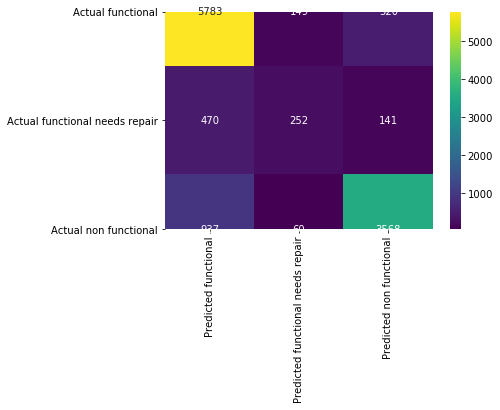

In [41]:
y_pred = pipeline.predict(X_val)
plot_confusion_matrix(y_val, y_pred)

In [45]:
# make a pipeline for a Decision Tree Classifier model
# to compare accuracy results (different features than earlier work)
from sklearn.tree import DecisionTreeClassifier

DTC_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42)
)

p_dist = {'decisiontreeclassifier__max_depth': [5, 10, 15, 20, None], 
          'decisiontreeclassifier__max_features': uniform(0, 1),
         }

DTC_search = RandomizedSearchCV(
    DTC_pipeline,
    param_distributions=p_dist,
    n_iter=10,
    cv=4,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1,
    
)

DTC_search.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:    5.4s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  19 out of  40 | elapsed:    6.3s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  24 out of  40 | elapsed:    6.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  29 out of  40 | elapsed:    7.5s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:    7.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.0s finished


RandomizedSearchCV(cv=4, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            f

In [47]:
print(DTC_search.best_estimator_)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type', 'management',
                                      'management_group', 'payment_type',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'waterpoint_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': '...
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=15,
                                        max_features=0.839006158

In [49]:
pipeline2 = DTC_search.best_estimator_
print ('Validation Accuracy', pipeline2.score(X_val, y_val))

Validation Accuracy 0.7733164983164983


In [144]:
# test_3 = pipeline.predict(X_test)
# submissionR = sample_submission.copy()
# submissionR['status_group'] = test_3
# submissionR.to_csv('Kaggle_water_Eric_Ramon_3.csv', index=False)